In [1]:
import os
import time
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

RANDOM_STATE = 42 

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
def load_data(local_path="clean_outliers_data.csv", folder="datas"):
    file_path = os.path.join(folder, local_path)

    if os.path.exists(file_path):
        print(f"Loaded dataset from local file: {file_path}")
        df = pd.read_csv(file_path)
        return df
    else:
        raise FileNotFoundError(f"File not found: {file_path}")

df = load_data()

Loaded dataset from local file: datas\clean_outliers_data.csv


In [3]:
def basic_eda(df):
    print("== Dataset Info ==")
    df.info()
    
    print("\n== Head ==")
    print(df.head())
    
    print("\n== Missing values (top 20) ==")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    
    if missing.empty:
        print("No missing values detected.")
    else:
        print(missing.head(20))
    
    print("\n== Target distribution ==")
    target_cols = [
        c for c in df.columns
        if any(key in c.lower() for key in ["bankrupt", "class", "label", "target"])
    ]
    
    target_col = target_cols[0] if target_cols else df.columns[-1]
    print(f"Detected target column: {target_col}")
    print(df[target_col].value_counts())
    
    return target_col


In [4]:
target_col = basic_eda(df)

== Dataset Info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539 entries, 0 to 5538
Data columns (total 12 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 5539 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  5539 non-null   float64
 2    Net Value Per Share (B)                                  5539 non-null   float64
 3    Persistent EPS in the Last Four Seasons                  5539 non-null   float64
 4    Debt ratio %                                             5539 non-null   float64
 5    Borrowing dependency                                     5539 non-null   float64
 6    Working Capital to Total Assets                          5539 non-null   float64
 7    Current Liability to Assets                              5539 non-null   float64
 8  

In [5]:
def prepare_features_labels(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)
    return X, y

X, y = prepare_features_labels(df, target_col)
print(f"Features: {X.shape}, Labels: {y.shape}")


Features: (5539, 11), Labels: (5539,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (4154, 11), Test: (1385, 11)


CLASS DISTRIBUTION AFTER TRAIN-TEST SPLIT

TRAINING SET:
Total samples: 4154
Class 0 (Non-bankrupt): 4076 samples (98.12%)
Class 1 (Bankrupt): 78 samples (1.88%)

TEST SET:
Total samples: 1385
Class 0 (Non-bankrupt): 1359 samples (98.12%)
Class 1 (Bankrupt): 26 samples (1.88%)

ORIGINAL FULL DATASET:
Total samples: 5539
Class 0 (Non-bankrupt): 5435 samples (98.12%)
Class 1 (Bankrupt): 104 samples (1.88%)


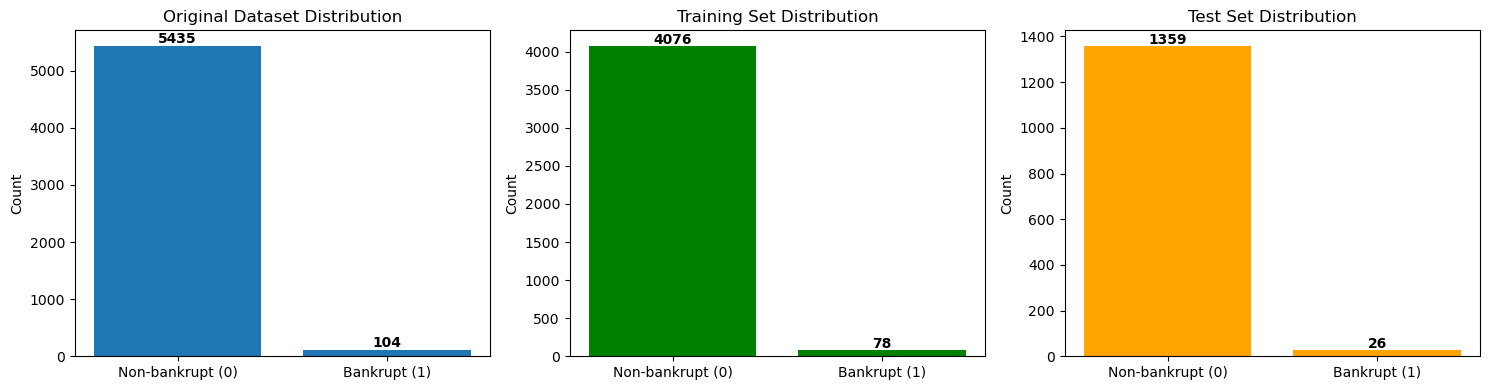

In [7]:
print("=" * 50)
print("CLASS DISTRIBUTION AFTER TRAIN-TEST SPLIT")
print("=" * 50)

# Check training set distribution
print("\nTRAINING SET:")
print(f"Total samples: {len(y_train)}")
print(f"Class 0 (Non-bankrupt): {(y_train == 0).sum()} samples ({100*(y_train == 0).mean():.2f}%)")
print(f"Class 1 (Bankrupt): {(y_train == 1).sum()} samples ({100*(y_train == 1).mean():.2f}%)")

# Check test set distribution  
print("\nTEST SET:")
print(f"Total samples: {len(y_test)}")
print(f"Class 0 (Non-bankrupt): {(y_test == 0).sum()} samples ({100*(y_test == 0).mean():.2f}%)")
print(f"Class 1 (Bankrupt): {(y_test == 1).sum()} samples ({100*(y_test == 1).mean():.2f}%)")

# Check original distribution
print("\nORIGINAL FULL DATASET:")
print(f"Total samples: {len(y)}")
print(f"Class 0 (Non-bankrupt): {(y == 0).sum()} samples ({100*(y == 0).mean():.2f}%)")
print(f"Class 1 (Bankrupt): {(y == 1).sum()} samples ({100*(y == 1).mean():.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original dataset
y_counts = y.value_counts()
axes[0].bar(['Non-bankrupt (0)', 'Bankrupt (1)'], y_counts.values)
axes[0].set_title('Original Dataset Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(y_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Training set
y_train_counts = y_train.value_counts()
axes[1].bar(['Non-bankrupt (0)', 'Bankrupt (1)'], y_train_counts.values, color='green')
axes[1].set_title('Training Set Distribution')
axes[1].set_ylabel('Count')
for i, v in enumerate(y_train_counts.values):
    axes[1].text(i, v + 30, str(v), ha='center', fontweight='bold')

# Test set
y_test_counts = y_test.value_counts()
axes[2].bar(['Non-bankrupt (0)', 'Bankrupt (1)'], y_test_counts.values, color='orange')
axes[2].set_title('Test Set Distribution')
axes[2].set_ylabel('Count')
for i, v in enumerate(y_test_counts.values):
    axes[2].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [8]:
baseline_rf = RandomForestClassifier(
    random_state=RANDOM_STATE, n_estimators=500, class_weight="balanced_subsample", n_jobs=-1
)
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

baseline_rf.fit(X_train_imputed, y_train)
baseline_proba = baseline_rf.predict_proba(X_test_imputed)[:, 1]
print("Baseline RF ROC-AUC:", roc_auc_score(y_test, baseline_proba))

Baseline RF ROC-AUC: 0.8682713533706912


In [9]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

roc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []


In [10]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n=== Fold {fold} ===")
    
    # 🔒 CV happens ONLY on training set
    X_train_cv = X_train.iloc[train_idx]
    X_val_cv   = X_train.iloc[val_idx]
    y_train_cv = y_train.iloc[train_idx]
    y_val_cv   = y_train.iloc[val_idx]
    
    # Pipeline (no leakage, no SMOTE)
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=500,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
    
    # Train
    model.fit(X_train_cv, y_train_cv)
    
    # Validate (probabilities first!)
    y_val_proba = model.predict_proba(X_val_cv)[:, 1]
    
    # Default threshold (can tune later)
    y_val_pred = (y_val_proba >= 0.5).astype(int)
    
    # Metrics
    roc_scores.append(roc_auc_score(y_val_cv, y_val_proba))
    recall_scores.append(recall_score(y_val_cv, y_val_pred, zero_division=0))
    precision_scores.append(precision_score(y_val_cv, y_val_pred, zero_division=0))
    f1_scores.append(f1_score(y_val_cv, y_val_pred, zero_division=0))
    accuracy_scores.append(accuracy_score(y_val_cv, y_val_pred))
    
    print(
        f"ROC-AUC: {roc_scores[-1]:.4f} | "
        f"Recall: {recall_scores[-1]:.4f} | "
        f"Precision: {precision_scores[-1]:.4f} | "
        f"F1: {f1_scores[-1]:.4f}"
    )


=== Fold 1 ===
ROC-AUC: 0.9059 | Recall: 0.0000 | Precision: 0.0000 | F1: 0.0000

=== Fold 2 ===
ROC-AUC: 0.8137 | Recall: 0.0000 | Precision: 0.0000 | F1: 0.0000

=== Fold 3 ===
ROC-AUC: 0.7872 | Recall: 0.0625 | Precision: 0.5000 | F1: 0.1111

=== Fold 4 ===
ROC-AUC: 0.8604 | Recall: 0.0000 | Precision: 0.0000 | F1: 0.0000

=== Fold 5 ===
ROC-AUC: 0.9622 | Recall: 0.0667 | Precision: 0.5000 | F1: 0.1176


In [11]:
print("\n" + "=" * 50)
print("CROSS-VALIDATION SUMMARY")
print("=" * 50)

print(f"ROC-AUC   : {np.mean(roc_scores):.4f} ± {np.std(roc_scores):.4f}")
print(f"Recall   : {np.mean(recall_scores):.4f}")
print(f"F1 Score : {np.mean(f1_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Accuracy : {np.mean(accuracy_scores):.4f}")



CROSS-VALIDATION SUMMARY
ROC-AUC   : 0.8659 ± 0.0630
Recall   : 0.0258
F1 Score : 0.0458
Precision: 0.2000
Accuracy : 0.9793


In [12]:
final_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=800,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

final_model.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=800, n_jobs=-1,
                                        random_state=42))])

In [13]:
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = final_model.predict(X_test)

print("\n=== TEST SET PERFORMANCE ===")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Recall   : {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Accuracy : {accuracy_score(y_test, y_test_pred):.4f}")



=== TEST SET PERFORMANCE ===
ROC-AUC  : 0.8616
Recall   : 0.0000
F1 Score : 0.0000
Precision: 0.0000
Accuracy : 0.9805


In [14]:
# Predict probabilities on test set
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# Confirm ROC-AUC (ranking quality)
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

Test ROC-AUC: 0.8616


In [15]:
thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

print("THRESHOLD ANALYSIS")
print("=" * 60)

for t in thresholds:
    y_pred_t = (y_test_proba >= t).astype(int)
    
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    
    print(
        f"Threshold {t:>4.2f} | "
        f"Recall: {recall:.4f} | "
        f"Precision: {precision:.4f} | "
        f"F1: {f1:.4f}"
    )


THRESHOLD ANALYSIS
Threshold 0.05 | Recall: 0.6154 | Precision: 0.1212 | F1: 0.2025
Threshold 0.10 | Recall: 0.4231 | Precision: 0.1618 | F1: 0.2340
Threshold 0.15 | Recall: 0.2692 | Precision: 0.1556 | F1: 0.1972
Threshold 0.20 | Recall: 0.1923 | Precision: 0.1667 | F1: 0.1786
Threshold 0.25 | Recall: 0.1154 | Precision: 0.1500 | F1: 0.1304
Threshold 0.30 | Recall: 0.0769 | Precision: 0.1667 | F1: 0.1053


In [16]:
def evaluate_model(model, X_test, y_test, threshold=0.10):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print("=" * 50)
    print("MODEL EVALUATION ON TEST SET")
    print("=" * 50)
    print(f"Threshold used: {threshold}")
    print(f"ROC-AUC: {auc:.4f} | AP: {ap:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"AP = {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


MODEL EVALUATION ON TEST SET
Threshold used: 0.1
ROC-AUC: 0.8616 | AP: 0.1384
Accuracy: 0.9480
Precision: 0.1618 | Recall: 0.4231 | F1: 0.2340

Confusion Matrix:
[[1302   57]
 [  15   11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1359
           1       0.16      0.42      0.23        26

    accuracy                           0.95      1385
   macro avg       0.58      0.69      0.60      1385
weighted avg       0.97      0.95      0.96      1385



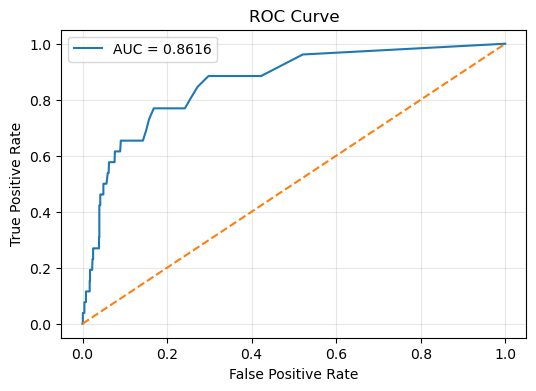

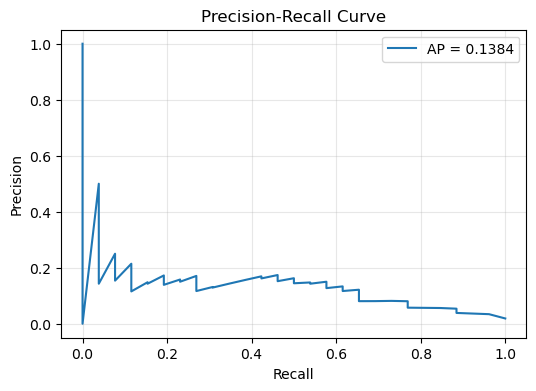

In [21]:
evaluate_model(final_model, X_test, y_test, threshold=0.10)


Feature Importances:
                                                 Feature  Importance
                                    Borrowing dependency    0.214796
                 Persistent EPS in the Last Four Seasons    0.125863
                                            Debt ratio %    0.113323
                       Retained Earnings to Total Assets    0.089073
                              Current Liabilities/Equity    0.086614
 ROA(C) before interest and depreciation before interest    0.080789
                      Net Income to Stockholder's Equity    0.080440
                     Current Liability to Current Assets    0.065091
                         Working Capital to Total Assets    0.052564
                                 Net Value Per Share (B)    0.046530
                             Current Liability to Assets    0.044918


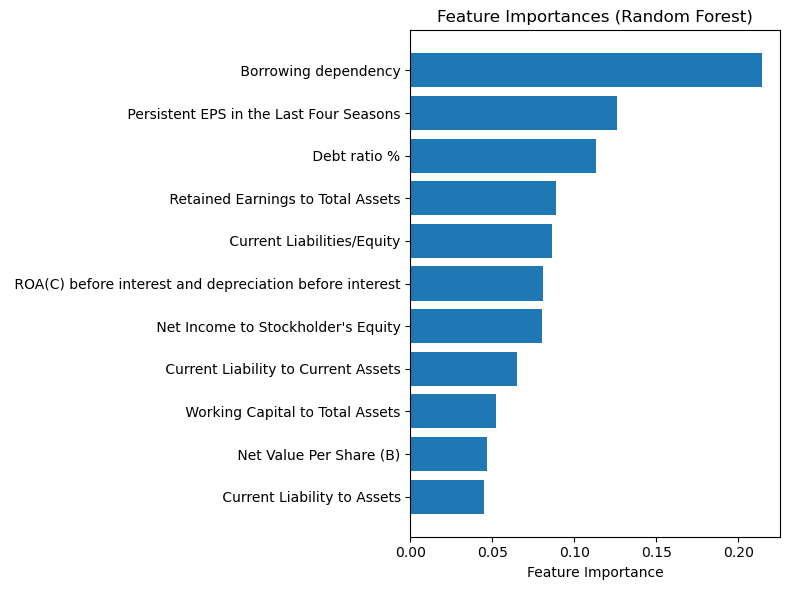

In [18]:
# Get trained Random Forest
rf = final_model.named_steps["rf"]

importances = rf.feature_importances_
feature_names = X_train.columns

# Create importance DataFrame (ALL features)
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print all feature importances
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=False)
print("\nFeature Importances:")
print(importance_df_sorted.to_string(index=False))

# Plot all features
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["Feature"][::-1],
    importance_df["Importance"][::-1]
)
plt.xlabel("Feature Importance")
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [19]:
os.makedirs("models", exist_ok=True)
joblib.dump(final_model, "models/trained_model.pkl")
print("Saved trained pipeline to models/trained_model.pkl")

Saved trained pipeline to models/trained_model.pkl
